[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dbamman/anlp25/blob/main/5.classification/TransformerClassification.ipynb)

**N.B.** Once it's open on Colab, remember to save a copy (by e.g. clicking `Copy to Drive` above).

---

Thie notebook explores using transformers for document classification.  Before starting, change the runtime to GPU: Runtime > Change runtime type > Hardware accelerator: GPU (any GPU is fine).

For an intro to models in PyTorch, see [this tutorial](https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html).




Download classification data for training/evaluation.

In [1]:
!wget https://raw.githubusercontent.com/dbamman/anlp25/main/data/convote/train.tsv
!wget https://raw.githubusercontent.com/dbamman/anlp25/main/data/convote/dev.tsv

--2025-10-07 23:45:24--  https://raw.githubusercontent.com/dbamman/anlp25/main/data/convote/train.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4660140 (4.4M) [text/plain]
Saving to: ‘train.tsv’

train.tsv           100%[===================>]   4.44M  --.-KB/s    in 0.03s   

2025-10-07 23:45:24 (148 MB/s) - ‘train.tsv’ saved [4660140/4660140]

--2025-10-07 23:45:24--  https://raw.githubusercontent.com/dbamman/anlp25/main/data/convote/dev.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 351382 (343K) [text/plain]
Saving t

In [2]:
import math
import sys
import torch
from torch import nn
from collections import Counter
from nltk import word_tokenize

In [4]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
# max sequence length
max_length=256

# limit vocabulary to top N words in training data
max_vocab=10000

# batch size
batch_size=128

# size of token representations (which dictates the size of the overall model).
d_model=16


# number of epochs
num_epochs=50

print('')
print("********************************************")
print("Running on: {}".format(device))
print("********************************************")
print('')


********************************************
Running on: cuda
********************************************



In [7]:
# PositionalEncoding class copied from:
# https://github.com/pytorch/examples/blob/main/word_language_model/model.py

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_length, d_model)
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)#.transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):

        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


In [8]:
class TransformerClassifier(torch.nn.Module):

    def __init__(self, num_labels, d_model, nhead=2, num_encoder_layers=1, dim_feedforward=256):

        super(TransformerClassifier, self).__init__()

        self.num_labels = num_labels
        self.embedding = nn.Embedding(num_embeddings=max_vocab+2, embedding_dim=d_model)
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            dim_feedforward=dim_feedforward,
            batch_first=True,
            dropout=0.5
        )
        self.classifier = nn.Linear(d_model, self.num_labels)
        self.pos_encoder = PositionalEncoding(d_model)

    def forward(self, x, m):

        # put data on device (e.g., gpu)
        x = x.to(device)
        m = m.to(device)

        # convert input token IDs to word embeddings
        embed = self.embedding(x)

        # add position encodings to include information about word position within the document
        embed = self.pos_encoder(embed)

        # get transformer output
        h = self.transformer.encoder(embed, src_key_padding_mask=m)

        # Represent document as average embedding of transformer output
        h = torch.mean(h, dim=1)

        # Convert document representation into output label space
        logits = self.classifier(h)

        return logits


In [9]:
def create_vocab_and_labels(filename, max_vocab):
    # This function creates the word vocabulary (and label ids) from the training data
    # The vocab is a mapping between word types and unique word IDs

    counts = Counter()
    labels = {}
    with open(filename, encoding="utf-8") as file:
        for line in file:
            cols = line.rstrip().split("\t")
            lab = cols[0]
            text = word_tokenize(cols[1].lower())
            for tok in text:
                counts[tok] += 1

            if lab not in labels:
                labels[lab] = len(labels)

    vocab = {"[MASK]":0, "[UNK]":1}

    for k,v in counts.most_common(max_vocab):
        vocab[k] = len(vocab)

    return vocab, labels

In [10]:
def read_data(filename, vocab, labels, max_length, max_docs=5000):
    # Read in data from file, up to the first max_docs documents. For each document
    # read up to max_length tokens.

    x = []
    y = []
    m = []

    with open(filename, encoding="utf-8") as file:
        for idx, line in enumerate(file):
            if idx >= max_docs:
                break
            cols = line.rstrip().split("\t")
            lab = cols[0]
            text = word_tokenize(cols[1])
            text_ids = []
            for tok in text:
                if tok in vocab:
                    text_ids.append(vocab[tok])
                else:
                    text_ids.append(vocab["[UNK]"])

            text_ids = text_ids[:max_length]

            # PyTorch (and most libraries that deal with matrix operations) expects all inputs to be the same length
            # So pad each document with 0s up to max_length
            # But keep track of the true number of tokens in the document with the "mask" list.

            # True tokens have a mask value of 0
            mask = [0] * len(text_ids)

            for i in range(len(text_ids), max_length):
                text_ids.append(vocab["[MASK]"])
                # Padded tokens have a mask value of 1
                mask.append(1)

            x.append(text_ids)
            m.append(mask)
            y.append(labels[lab])

    return x, y, m

In [11]:
def get_batches(x, y, m, batch_size):

    # Create minibatches from the full dataset

    batches_x = []
    batches_y = []
    batches_m = []
    for i in range(0, len(x), batch_size):
        xbatch = x[i:i+batch_size]
        ybatch = y[i:i+batch_size]
        mbatch = m[i:i+batch_size]

        batches_x.append(torch.LongTensor(xbatch))
        batches_y.append(torch.LongTensor(ybatch))
        batches_m.append(torch.BoolTensor(mbatch))

    return batches_x, batches_y, batches_m

In [12]:
def evaluate(model, all_x, all_y, all_m):

    # Calculate accuracy

    model.eval()
    corr = 0.
    total = 0.
    with torch.no_grad():
        for x, y, m in zip(all_x, all_y, all_m):
            y_preds = model.forward(x, m)
            for idx, y_pred in enumerate(y_preds):
                prediction = torch.argmax(y_pred)
                if prediction == y[idx]:
                    corr += 1.
                total += 1
    return corr / total

In [13]:
def train(model, model_filename, train_x, train_y, train_m, dev_x, dev_y, dev_m, shuffle=False):

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    cross_entropy = nn.CrossEntropyLoss()

    # Keep track of the epoch that has the best dev accuracy
    best_dev_acc = 0.
    best_dev_epoch = None

    losses = []

    # How many epochs with no changes before we quit
    patience = 20

    dev_batches_x, dev_batches_y, dev_batches_m = get_batches(dev_x, dev_y, dev_m, batch_size=batch_size)

    for epoch in range(num_epochs):

        model.train()

        if shuffle:
            # shuffle batches
            shuffled_idx = torch.randperm(len(train_x))
            train_x = [train_x[i] for i in shuffled_idx]
            train_y = [train_y[i] for i in shuffled_idx]
            train_m = [train_m[i] for i in shuffled_idx]

        train_batches_x, train_batches_y, train_batches_m = get_batches(train_x, train_y, train_m, batch_size=batch_size)

        for x, y, m in zip(train_batches_x, train_batches_y, train_batches_m):
            # Get predictions for batch x (with mask values m)
            y_pred = model.forward(x, m)
            y = y.to(device)

            # Calculate loss as cross-entropy with true labels
            loss = cross_entropy(y_pred.view(-1, model.num_labels), y.view(-1))

            # Set all gradients to zero
            optimizer.zero_grad()

            # Calculate gradients from current loss
            loss.backward()
            losses.append(loss.item())

            # Update parameters
            optimizer.step()

        dev_accuracy = evaluate(model, dev_batches_x, dev_batches_y, dev_batches_m)
        train_accuracy = evaluate(model, train_batches_x, train_batches_y, train_batches_m)

        # we're going to save the model that performs the best on *dev* data
        if dev_accuracy > best_dev_acc:
            torch.save(model.state_dict(), model_filename)
            print("%.3f is better than %.3f, saving model ..." % (dev_accuracy, best_dev_acc))
            best_dev_acc = dev_accuracy
            best_dev_epoch = epoch

        if epoch % 1 == 0:
            print("Epoch %s, dev accuracy: %.3f, train accuracy: %.3f" % (epoch, dev_accuracy, train_accuracy))

        if epoch-best_dev_epoch > patience:
          print("%s > patience (%s), stopping..." % (epoch-best_dev_epoch, patience))
          break

    model.load_state_dict(torch.load(model_filename))
    print("\nBest Performing Model achieves dev accuracy of : %.3f" % (best_dev_acc))

    return losses

In [14]:
vocab, labels = create_vocab_and_labels("train.tsv", max_vocab)
train_x, train_y, train_m = read_data("train.tsv", vocab, labels, max_length=max_length)
dev_x, dev_y, dev_m = read_data("dev.tsv", vocab, labels, max_length=max_length)

In [15]:
classifier = TransformerClassifier(num_labels=len(labels), d_model=100, dim_feedforward=512)
classifier = classifier.to(device)

train_x_batch, train_y_batch, train_m_batch = get_batches(train_x, train_y, train_m, batch_size=batch_size)
dev_x_batch, dev_y_batch, dev_m_batch = get_batches(dev_x, dev_y, dev_m, batch_size=batch_size)

losses = train(classifier, "test.model", train_x, train_y, train_m, dev_x, dev_y, dev_m)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


0.494 is better than 0.000, saving model ...
Epoch 0, dev accuracy: 0.494, train accuracy: 0.496
Epoch 1, dev accuracy: 0.494, train accuracy: 0.496
0.510 is better than 0.494, saving model ...
Epoch 2, dev accuracy: 0.510, train accuracy: 0.507
0.541 is better than 0.510, saving model ...
Epoch 3, dev accuracy: 0.541, train accuracy: 0.553
0.654 is better than 0.541, saving model ...
Epoch 4, dev accuracy: 0.654, train accuracy: 0.668
Epoch 5, dev accuracy: 0.623, train accuracy: 0.675
Epoch 6, dev accuracy: 0.646, train accuracy: 0.705
Epoch 7, dev accuracy: 0.634, train accuracy: 0.737
Epoch 8, dev accuracy: 0.646, train accuracy: 0.743
Epoch 9, dev accuracy: 0.646, train accuracy: 0.763
Epoch 10, dev accuracy: 0.642, train accuracy: 0.793
Epoch 11, dev accuracy: 0.615, train accuracy: 0.697
Epoch 12, dev accuracy: 0.638, train accuracy: 0.812
Epoch 13, dev accuracy: 0.630, train accuracy: 0.817
Epoch 14, dev accuracy: 0.611, train accuracy: 0.787
Epoch 15, dev accuracy: 0.595, trai

**Q1**. Play around with this transformer as implemented and experiment with how performance on the dev data changes as a function of `d_model`, `num_encoder_layers`, `nhead`, etc.).  Describe your experiments and report dev accuracy on them below.

In [19]:
# ============================================
# Q1: Transformer Hyperparameter Experiments
# ============================================

import time
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# ---- Experiment Runner ----
def run_experiment(
    d_model_val=100,
    nhead_val=2,
    num_layers_val=1,
    dim_ff_val=512,
    epochs=20,
    tag=None
):
    """Train and evaluate a TransformerClassifier with specified hyperparameters."""
    assert d_model_val % nhead_val == 0, "d_model must be divisible by nhead"

    global num_epochs
    old_epochs = num_epochs
    num_epochs = epochs

    model = TransformerClassifier(
        num_labels=len(labels),
        d_model=d_model_val,
        nhead=nhead_val,
        num_encoder_layers=num_layers_val,
        dim_feedforward=dim_ff_val
    ).to(device)

    model_file = tag or f"model_d{d_model_val}_L{num_layers_val}_H{nhead_val}.pt"

    start = time.time()
    _ = train(model, model_file, train_x, train_y, train_m, dev_x, dev_y, dev_m, shuffle=True)
    end = time.time()

    # Evaluate on dev data
    dev_x_b, dev_y_b, dev_m_b = get_batches(dev_x, dev_y, dev_m, batch_size=batch_size)
    model.load_state_dict(torch.load(model_file, map_location=device))
    dev_acc = evaluate(model, dev_x_b, dev_y_b, dev_m_b)

    num_epochs = old_epochs

    print(f"[{tag or 'exp'}] d_model={d_model_val}, layers={num_layers_val}, heads={nhead_val}, "
          f"dev_acc={dev_acc:.4f}, time={end-start:.1f}s")

    return {
        "tag": tag or "exp",
        "d_model": d_model_val,
        "layers": num_layers_val,
        "heads": nhead_val,
        "dev_acc": float(dev_acc)
    }

# ---- Baseline Run ----
print("\nRunning baseline configuration...\n")
baseline = run_experiment(d_model_val=100, nhead_val=2, num_layers_val=1, epochs=20, tag="baseline")
print("\nBaseline accuracy:", baseline["dev_acc"])

# ---- Grid Search ----
print("\nRunning grid search...\n")
d_models = [64, 100, 128, 256]
layers_list = [1, 2]
nheads = [2, 4, 8]

results = []

for d in d_models:
    for L in layers_list:
        for H in nheads:
            if d % H != 0:
                continue
            tag = f"d{d}_L{L}_H{H}"
            res = run_experiment(
                d_model_val=d,
                nhead_val=H,
                num_layers_val=L,
                dim_ff_val=512,
                epochs=20,
                tag=tag
            )
            results.append(res)

# ---- Aggregate Results ----
df = pd.DataFrame(results).sort_values("dev_acc", ascending=False).reset_index(drop=True)

print("\nTop Configurations by Dev Accuracy:\n")
display(df.head(10))

# ---- Visualization ----
plt.figure(figsize=(10,5))
plt.bar(df["tag"], df["dev_acc"])
plt.xticks(rotation=60, ha="right")
plt.ylabel("Dev Accuracy")
plt.title("Transformer Hyperparameter Sweep (Convote)")
plt.show()

# ---- Optional: Re-run Best Config Longer ----
print("\nRe-running best configuration for 50 epochs...\n")
best_config = df.iloc[0]
best_long = run_experiment(
    d_model_val=best_config["d_model"],
    nhead_val=best_config["heads"],
    num_layers_val=best_config["layers"],
    epochs=50,
    tag="best_long_run"
)
print("\nBest long-run config:", best_long)



Running baseline configuration...

0.506 is better than 0.000, saving model ...
Epoch 0, dev accuracy: 0.506, train accuracy: 0.504
0.556 is better than 0.506, saving model ...
Epoch 1, dev accuracy: 0.556, train accuracy: 0.542
Epoch 2, dev accuracy: 0.541, train accuracy: 0.552
0.572 is better than 0.556, saving model ...
Epoch 3, dev accuracy: 0.572, train accuracy: 0.620
0.619 is better than 0.572, saving model ...
Epoch 4, dev accuracy: 0.619, train accuracy: 0.648
0.626 is better than 0.619, saving model ...
Epoch 5, dev accuracy: 0.626, train accuracy: 0.683
0.634 is better than 0.626, saving model ...
Epoch 6, dev accuracy: 0.634, train accuracy: 0.715
0.669 is better than 0.634, saving model ...
Epoch 7, dev accuracy: 0.669, train accuracy: 0.753
Epoch 8, dev accuracy: 0.654, train accuracy: 0.722
Epoch 9, dev accuracy: 0.603, train accuracy: 0.741
0.677 is better than 0.669, saving model ...
Epoch 10, dev accuracy: 0.677, train accuracy: 0.800
0.681 is better than 0.677, sav

KeyboardInterrupt: 

**Q2**. Here is some code that plots the loss curve over training. Plot the loss curve.

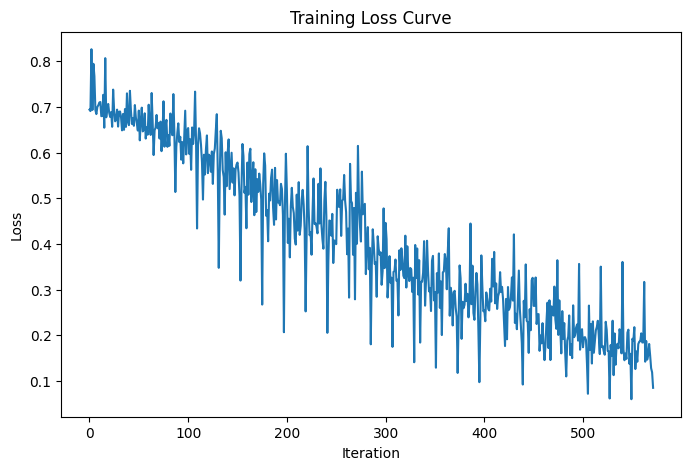

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the plotting function
def plot_loss_curve(losses):
    plt.figure(figsize=(8,5))
    sns.lineplot(x=range(len(losses)), y=losses)
    plt.title("Training Loss Curve")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()

# Plot the loss curve from your previous training
plot_loss_curve(losses)


Do you notice any regularities in the loss? Instantiate a new classifier, but this time train with `shuffle=True`.

In [21]:
new_classifier = TransformerClassifier(num_labels=len(labels), d_model=100, dim_feedforward=512)
new_classifier = new_classifier.to(device)

shuffled_losses = train(new_classifier, "test.model", train_x, train_y, train_m, dev_x, dev_y, dev_m, shuffle=True)

0.537 is better than 0.000, saving model ...
Epoch 0, dev accuracy: 0.537, train accuracy: 0.556
0.619 is better than 0.537, saving model ...
Epoch 1, dev accuracy: 0.619, train accuracy: 0.607
0.623 is better than 0.619, saving model ...
Epoch 2, dev accuracy: 0.623, train accuracy: 0.603
0.654 is better than 0.623, saving model ...
Epoch 3, dev accuracy: 0.654, train accuracy: 0.669
Epoch 4, dev accuracy: 0.634, train accuracy: 0.689
Epoch 5, dev accuracy: 0.654, train accuracy: 0.726
Epoch 6, dev accuracy: 0.638, train accuracy: 0.723
Epoch 7, dev accuracy: 0.646, train accuracy: 0.773
Epoch 8, dev accuracy: 0.642, train accuracy: 0.783
0.658 is better than 0.654, saving model ...
Epoch 9, dev accuracy: 0.658, train accuracy: 0.807
0.673 is better than 0.658, saving model ...
Epoch 10, dev accuracy: 0.673, train accuracy: 0.805
Epoch 11, dev accuracy: 0.630, train accuracy: 0.825
Epoch 12, dev accuracy: 0.619, train accuracy: 0.821
Epoch 13, dev accuracy: 0.607, train accuracy: 0.83

Plot the loss curve of this training run. How do the loss curves compare? **Consider:** why is it generally desirable to shuffle the training data at the beginning of each epoch when performing gradient descent?

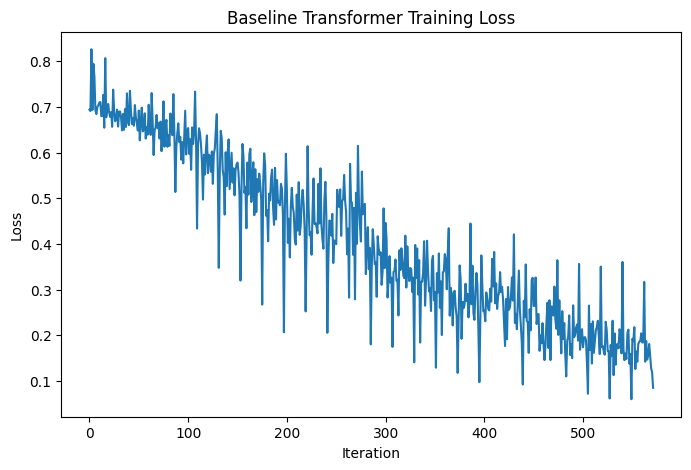

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_loss_curve(losses, title="Training Loss Curve"):
    plt.figure(figsize=(8,5))
    sns.lineplot(x=range(len(losses)), y=losses)
    plt.title(title)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()

plot_loss_curve(losses, title="Baseline Transformer Training Loss")
